# Using CEBRA on open neuroscience data from dandi

This example notebook is part of the [CEBRA](https://cebra.ai) workshop done at
[NeuroDataReHack 2023](https://neurodatawithoutborders.github.io/nwb_hackathons/HCK16_2023_Granada_RH/) in Granada, Spain.
If you are interested in the version used at the workshop, have a look at https://stes.io/NeuroDataReHack2023/.

It is recommended that you run this notebook directly in Google colab, but if you are fine with a manual install, you can set it up on your local environment as well.

## Additional software dependencies

We will use a few software libraries for data loading and processing, including:

- `dandi`, for accessing datasets on the https://dandiarchive.org/. The datasets are provided in [Neurodata Without Borders (NWB)](https://www.nwb.org/) format.
- [`pynwb`](https://pynwb.readthedocs.io/en/stable/) is the python interface for loading NWB files.
- [`nlb_tools`](https://github.com/neurallatents/nlb_tools) is a useful library to interface a subset of dandi/nwb datasets and take care of pre-processing. It was developed by the [Neural Latents Benchmark](https://neurallatents.github.io/) team. Note that if you want to use other Dandi datasets, you might need to specify some custom loading/pre-processing functions.

We will install some requirements now:

In [1]:
# This installs the requirements listed above with the latest version of CEBRA
! pip install -q --no-cache-dir dandi nlb_tools pynwb git+https://github.com/adaptivemotorcontrollab/cebra.git@a21ba0 2>/dev/null

# You can also install the latest version of CEBRA available on PyPI using
#! pip install -q --no-cache-dir dandi nlb_tools pynwb cebra

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


The following global configuration variables are useful if you want to run all cells in the notebook at once.

If `TRAIN_MODELS` is the to `True`, the notebook will train a set of CEBRA models from scratch which will take a few minutes. If you set it to `False`, pre-trained models will be downloaded from [FigShare](https://figshare.com/s/a4bbe105f11f67481681), allowing faster exploration.

If you want to train the models yourself, `MAX_ITERATIONS` is used below to limit the number of training steps. On the dataset we're going to use, about 15,000 steps seems to be a good number. For quickly testing that the notebook runs through, you can also specify less steps.

In [2]:
TRAIN_MODELS = False
MAX_ITERATIONS = 15_000

## Dataset preparation and exploration

### Dataset download

This tutorial uses the RTT dataset [1] from [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95). A few additional ressources on the dataset are available here:

- https://github.com/neurallatents/neurallatents.github.io/blob/master/notebooks/mc_rtt.ipynb
- https://dandiarchive.org/dandiset/000129
- https://zenodo.org/record/3854034
- https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95

Dataset credits:

> [1] O'Doherty, Joseph E., Cardoso, Mariana M. B., Makin, Joseph G., & Sabes, Philip N. (2020). Nonhuman Primate Reaching with Multichannel Sensorimotor Cortex Electrophysiology [Data set]. Zenodo. https://doi.org/10.5281/zenodo.3854034
>
> [2] Makin, J.G., O'Doherty, J.E., Cardoso, M.M. and Sabes, P.N., 2018. Superior arm-movement decoding from cortex with a new, unsupervised-learning algorithm. Journal of neural engineering, 15(2), p.026010.

In [3]:
! dandi download https://dandiarchive.org/dandiset/000129/draft

2023-09-05 09:25:49,832 [    INFO] NumExpr defaulting to 2 threads.
PATH                                                     SIZE     DONE    DONE% CHECKSUM STATUS    MESSAGE          
000129/dandiset.yaml                                                                     skipped   no change        
000129/sub-Indy/sub-Indy_desc-test_ecephys.nwb                                           error     FileExistsError  
000129/sub-Indy/sub-Indy_desc-train_behavior+ecephys.nwb                                 error     FileExistsError  
Summary:                                                 0 Bytes  0 Bytes                1 skipped 1 no change      
                                                         +51.0 MB 0.00%                  2 error   2 FileExistsError
2023-09-05 09:25:54,942 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20230905092548Z-33778.log


### Dataset loading

We will now load the dataset using `nlb_tools`. More detail and additional plots are also provided [in the `NLB` repository](https://github.com/neurallatents/neurallatents.github.io/blob/master/notebooks/mc_rtt.ipynb), and in the [`nlb_tools` source code](https://github.com/neurallatents/nlb_tools/blob/main/nlb_tools/nwb_interface.py#L18).

For convenience, we'll simply load the dataset keys as variables directly into the global namespace of the notebook (e.g., `spikes`, `cursor_pos`, etc.).

To make computations a bit faster, we will bin the whole dataset into 20ms bins. Feel free to vary this parameter (but note that smaller bin sizes will take a bit longer to train).

In [4]:
import numpy as np
from nlb_tools.nwb_interface import NWBDataset

class Dataset(NWBDataset):

    def __init__(self):

        super().__init__("./000129/sub-Indy", "*train", split_heldout=False)
        self.resample(target_bin = 20)

        for signal_type in set(self.data.columns.get_level_values(level = 0)):
            print(signal_type, self.data[signal_type].shape)
            setattr(self, signal_type, self.data[signal_type].values)

        values = [tuple(v) for v in self.target_pos]
        unique_values = list(sorted(set([v for v in values if not np.isnan(v).any()])))
        self.target_pos_idx = np.array([-1 if np.isnan(v).any() else unique_values.index(v) for v in values], dtype = int)

dataset = Dataset()

print("Loaded dataset:")
display(dataset.data.head())

finger_pos (32455, 3)
target_pos (32455, 2)
spikes (32455, 130)
finger_vel (32455, 2)
cursor_pos (32455, 2)
Loaded dataset:


signal_type            cursor_pos            finger_pos             \
channel                         x          y          x          y   
clock_time                                                           
0 days 00:00:00         -2.291894  29.804970  -2.285280  29.793050   
0 days 00:00:00.020000  -4.729784  61.716366  -4.712008  61.687814   
0 days 00:00:00.040000  -4.111395  54.078738  -4.094851  54.053797   
0 days 00:00:00.060000  -4.394558  58.233410  -4.376490  58.206869   
0 days 00:00:00.080000  -4.133870  55.408485  -4.112566  55.378696   

signal_type                        finger_vel           spikes            ...  \
channel                          z          x         y    201  203  204  ...   
clock_time                                                                ...   
0 days 00:00:00          49.734907   0.687648 -1.302546    0.0  0.0  0.0  ...   
0 days 00:00:00.020000  103.027237   1.709249 -3.072933    0.0  0.0  0.0  ...   
0 days 00:00:00.040000   90.357359   1.877808 -3.158982    0.0  1.0  0.0  ...   
0 days 00:00:00.060000   97.376227   2.411500 -3.859006    0.0  0.0  0.0  ...   
0 days 00:00:00.080000   92.765626   2.897537 -4.433531    0.0  0.0  1.0  ...   

signal_type                                                    target_pos  \
channel                9201 9203 9301 9403 9501 9502 9601 9602          x   
clock_time                                                                  
0 days 00:00:00         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0       -7.5   
0 days 00:00:00.020000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   
0 days 00:00:00.040000  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0       -7.5   
0 days 00:00:00.060000  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0       -7.5   
0 days 00:00:00.080000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   

signal_type                   
channel                    y  
clock_time                    
0 days 00:00:00         52.5  
0 days 00:00:00.020000  52.5  
0 days 00:00:00.040000  52.5  
0 days 00:00:00.060000  52.5  
0 days 00:00:00.080000  52.5  

[5 rows x 139 columns]

### Data Visualization

From the previous step, we know that the dataset contains a range of different behavioral variables. Here we visualize one of them, the cursor position `cursor_pos` along with the target position `target_pos`.

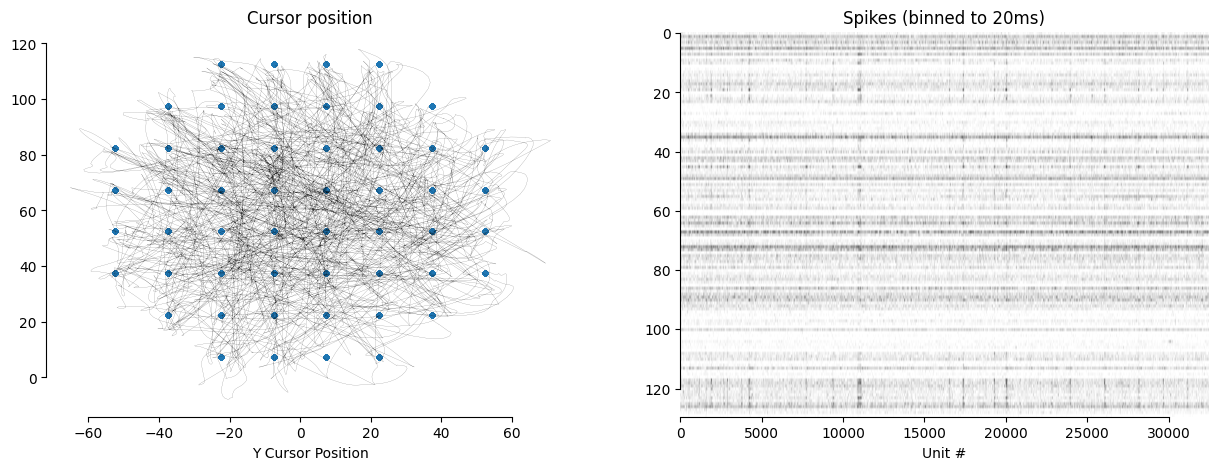

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def pretty_plot(ax = None):
    if ax is None:
        ax = plt.gca()
    sns.despine(ax=ax, trim = True)


fig, axes = plt.subplots(1,2,figsize = (15,5))

axes[0].set_title("Cursor position")
axes[0].plot(dataset.cursor_pos[:, 0], dataset.cursor_pos[:, 1], alpha = .8, c = "black", linewidth = 0.1)
axes[0].scatter(dataset.target_pos[:, 0], dataset.target_pos[:, 1], s = 10, alpha = 1, c = "C0")
axes[0].set_xlabel("X Cursor Position")
axes[0].set_xlabel("Y Cursor Position")
pretty_plot(axes[0])

axes[1].set_title("Spikes (binned to 20ms)")
axes[1].imshow(dataset.spikes[:, :].T > 0, cmap = "gray_r", aspect = "auto")
axes[1].set_xlabel("Time Bin")
axes[1].set_xlabel("Unit #")
pretty_plot(axes[1])

plt.show()

### Additional notes

Note that the dataset is provided in two splits, and here we only use the `train` section of the data. Hence, a few numbers in the dataset will have `NaN` values, as visualized below.

If you are interested in training a model on the full dataset, you can load the whole dataset by running

```python
dataset = NWBDataset("./000129/sub-Indy", "*", split_heldout=False)
```

instead of

```python
dataset = NWBDataset("./000129/sub-Indy", "*train", split_heldout=False)
```

above. Here is a visualization:

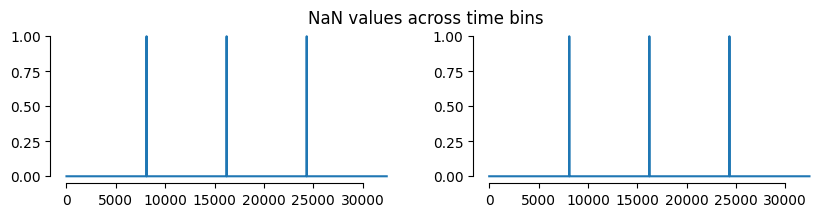

In [6]:
fig, axes = plt.subplots(1,2,figsize = (10,2))
plt.suptitle("NaN values across time bins")
axes[0].plot(np.isnan(dataset.cursor_pos).any(axis = 1))
axes[1].plot(np.isnan(dataset.spikes).any(axis = 1))
for ax in axes: pretty_plot(ax)
plt.show()

## CEBRA Analysis

We will now use the CEBRA software library to train and visualize a model on the RTT dataset. ``cebra.CEBRA`` is the main model class using our high-level sci-kit learn interface for training models.

Extensive documentation on possible parameters is provided in the [API docs](https://cebra.ai/docs/api/sklearn/cebra.html).

The [demo notebooks](https://cebra.ai/docs/demos.html) provide additional guidance on how to set parameters in different application scenarios.

### Model setup

In [7]:
import cebra

def init_model():
    return cebra.CEBRA(
        # Our selected model will use 10 time bins (200ms) as its input
        model_architecture = "offset10-model",

        # We will use mini-batches of size 1000 for optimization. You should
        # generally pick a number greater than 512, and larger values (if they
        # fit into memory) are generally better.
        batch_size = 1000,

        # This is the number of steps to train. I ran an example with 10_000
        # which resulted in a usable embedding, but training longer might further
        # improve the results
        max_iterations = MAX_ITERATIONS,

        # This will be the number of output features. The optimal number depends
        # on the complexity of the dataset.
        output_dimension = 8,

        # If you want to see a progress bar during training, specify this
        verbose = True

        # There are many more parameters to explore. Head to
        # https://cebra.ai/docs/api/sklearn/cebra.html to explore them.
    )

model = init_model()

### Model training

We'll remove the `NaN` timesteps (the test-set) here, and only train on the remaining time-steps. We use spikes and the cursor position here.

**Question:** Try to use other behavior variables for supervision. How do they influence the embeddings?

After training, you can optionally save the model. Just remember that in google colab, the local storage will be cleared at some point. So if you want to keep your model, move it e.g. to your google drive, or download it.

If the global `TRAIN_MODELS` flag is set to `False` (see top of the notebook), we'll just load a pre-trained model at this point. The models are stored on [FigShare](https://figshare.com/s/a4bbe105f11f67481681).

In [8]:
is_nan = np.isnan(dataset.spikes).any(axis = 1) # we'll filter the NaN values here

In [9]:
if TRAIN_MODELS:
    model.fit(
        dataset.spikes[~is_nan],
        dataset.cursor_pos[~is_nan]
    )
    # Optionally, save the model
    # model.save("230904_dandi_model_example.pth")
else:
    ! wget -qO models.zip -nc https://figshare.com/ndownloader/articles/24082332?private_link=a4bbe105f11f67481681
    ! unzip -o models.zip
    model = cebra.CEBRA.load("230904_dandi_model_example.pth")

Archive:  models.zip
 extracting: 230904_dandi_model_example.pth  
 extracting: 230905_model_target_pos_index_15k.pth  
 extracting: 230905_model_finger_vel_15k.pth  
 extracting: 230905_model_finger_pos_15k.pth  
 extracting: 230905_model_cursor_pos_15k.pth  


Plots below are generated with a model I trained. Results might look different for you, but the embeddings will be consistent up to a linear transform with my model!

### Loss curve during training

We will first check the loss value. CEBRA is trained with an InfoNCE loss. In the worst case, the loss will have value `log(batch_size)` which corresponds to a "random" / non-meaningful embedding.

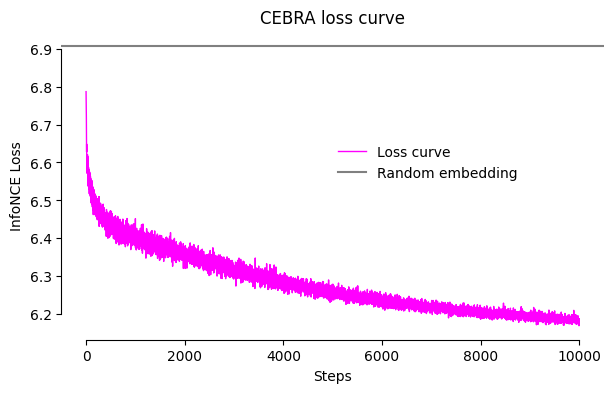

In [10]:
import math

cebra.plot_loss(model, label = "Loss curve")

plt.axhline(math.log(model.batch_size), c = "gray", label = "Random embedding")
plt.legend(frameon = False, loc = (.5, .5))
pretty_plot()
plt.title("CEBRA loss curve")
plt.show()

### Embedding Visualization

After confirming that the loss curve converges, we can check the embeddings.

In [11]:
is_nan = np.isnan(dataset.spikes).any(axis = 1) # we'll filter the NaN values here

embedding = model.transform(dataset.spikes[~is_nan])

We can conveniently plot embeddings using the `cebra.plot_embedding` helper function. Here we plot the embedding against the cursor x and y coordinates

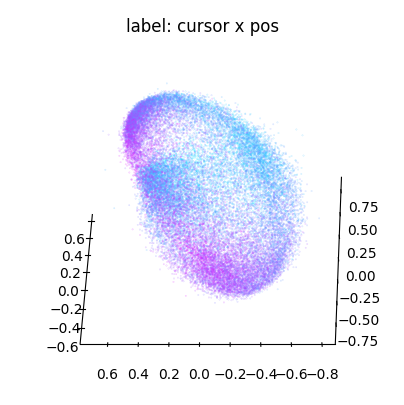

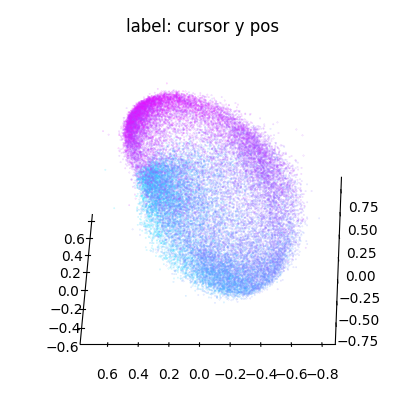

In [12]:
ax_x = cebra.plot_embedding(embedding, embedding_labels = dataset.cursor_pos[~is_nan, 0], title = "label: cursor x pos")
ax_x.view_init(azim = 180)

ax_y = cebra.plot_embedding(embedding, embedding_labels = dataset.cursor_pos[~is_nan, 1], title = "label: cursor y pos")
ax_y.view_init(azim = 180)

Note that the embedding is 8-dimensional. While the y dimension looked pretty well correlated with the embedding, this seems less the case for the x dimension.

The chosen dimensions above (`[0,1,2]`) are arbitrarily picked. Let's improve this in the following and explore more dimension in the embedding! A useful strategy to filter the best dimensions to visualize is to run a regression model against each embedding dimension and compute the R² score:

In [13]:
from sklearn.linear_model import LinearRegression

score = np.zeros(embedding.shape[1])
for dim in range(embedding.shape[1]):
    X,y = embedding[:,dim:dim+1], dataset.cursor_pos[~is_nan]
    score[dim] = LinearRegression().fit(X, y).score(X, y)

print("All scores:\t", score.round(3))

All scores:	 [0.177 0.023 0.294 0.316 0.284 0.254 0.147 0.269]


In [14]:
best_idc = np.argsort(-score)[:3]

print("Best scores:\t", score[best_idc].round(3))
print("For indices:\t", best_idc)

Best scores:	 [0.316 0.294 0.284]
For indices:	 [3 2 4]


Now, let's visualize the three dimensions with the best scores:

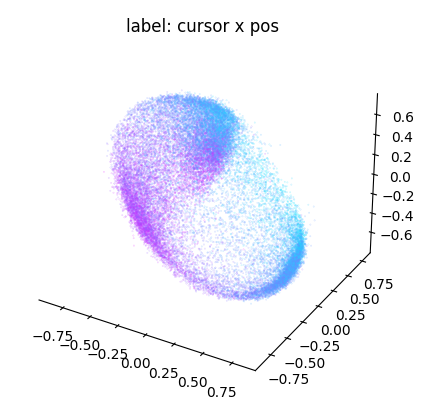

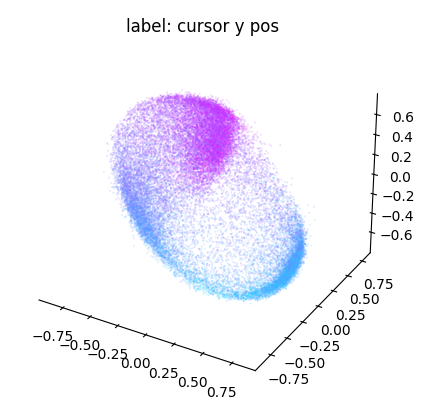

In [15]:
ax = cebra.plot_embedding(
    embedding[:, best_idc],
    embedding_labels = dataset.cursor_pos[~is_nan, 0],
    title = "label: cursor x pos"
)
plt.show()

ax = cebra.plot_embedding(
    embedding[:, best_idc],
    embedding_labels = dataset.cursor_pos[~is_nan, 1],
    title = "label: cursor y pos"
)
plt.show()

## Next steps

A lot of additional demo notebooks are available on the CEBRA homepage. The techniques discussed there are also useful for adding analysis to this tutorial notebook. Possible tutorial questions to investigate are listed below each of the references.

- [Hypothesis-driven and discovery-driven analysis with CEBRA](https://cebra.ai/docs/demo_notebooks/Demo_hypothesis_testing.html).
   - train embeddings with different behavioral inputs, and compare their goodness of fit. Which behavioral variable is represented best in the given dataset?
- [Consistency: CEBRA for consistent and interpretable embeddings](https://cebra.ai/docs/demo_notebooks/Demo_consistency.html).
    - The data is split into four different chunks by the train/test split. How consistent are the embeddings between these chunks?
- [Decoding from a CEBRA embedding](https://cebra.ai/docs/demo_notebooks/Demo_decoding.html)
    - add a kNN decoder on top of the embeddings, which predicts either the current cursor position, or the final target position
- [Training embeddings with in Euclidean space vs. on the hypersphere](https://cebra.ai/docs/demo_notebooks/Demo_primate_reaching_mse_loss.html).
    - Adapt the loss function and train embeddings in Euclidean space.
- The demos also provide [results on a different reaching dataset](https://cebra.ai/docs/demo_notebooks/Demo_primate_reaching.html).

## Contact

Steffen Schneider (if you have questions about this notebook):

- Email [stes@hey.com](mailto:stes@hey.com) or any of the contacts at [https://stes.io](https://stes.io)
- Twitter: [@stes_io](https://twitter.com/stes_io)

CEBRA

- Code (please give us a ⭐): [https://github.com/AdaptiveMotorControlLab/cebra](https://github.com/AdaptiveMotorControlLab/cebra)
- Twitter (follow for updates!): [https://twitter.com/CEBRAai](https://twitter.com/CEBRAai)
- Mathis Lab Homepage: https://www.mackenziemathislab.org/


# Supplementary Material

## Training multiple CEBRA models

In [16]:
# Training more models

if TRAIN_MODELS:

    model_cursor_pos = init_model()
    model_finger_vel = init_model()
    model_finger_pos = init_model()
    model_target_pos_index = init_model()

    model_cursor_pos.fit(
        dataset.spikes[~is_nan],
        dataset.cursor_pos[~is_nan]
    )

    model_finger_vel.fit(
        dataset.spikes[~is_nan],
        dataset.finger_vel[~is_nan]
    )

    model_finger_pos.fit(
        dataset.spikes[~is_nan],
        dataset.finger_pos[~is_nan]
    )

    model_target_pos_index.fit(
        dataset.spikes[~is_nan],
        dataset.target_pos_idx[~is_nan]
    )

    # Here is how to save the models locally
    #model_cursor_pos.save("230905_model_cursor_pos_15k.pth")
    #model_finger_vel.save("230905_model_finger_vel_15k.pth")
    #model_finger_pos.save("230905_model_finger_pos_15k.pth")
    #model_target_pos_index.save("230905_model_target_pos_index_15k.pth")

else:
    ! wget -qO models.zip -nc https://figshare.com/ndownloader/articles/24082332?private_link=a4bbe105f11f67481681
    ! unzip -o models.zip

    model_cursor_pos = cebra.CEBRA.load("230905_model_cursor_pos_15k.pth")
    model_finger_vel = cebra.CEBRA.load("230905_model_finger_vel_15k.pth")
    model_finger_pos = cebra.CEBRA.load("230905_model_finger_pos_15k.pth")
    model_target_pos_index = cebra.CEBRA.load("230905_model_target_pos_index_15k.pth")

Archive:  models.zip
 extracting: 230904_dandi_model_example.pth  
 extracting: 230905_model_target_pos_index_15k.pth  
 extracting: 230905_model_finger_vel_15k.pth  
 extracting: 230905_model_finger_pos_15k.pth  
 extracting: 230905_model_cursor_pos_15k.pth  


## Comparing different model loss curves

Below we visualize the InfoNCE loss (goodness of fit, lower is better) for various models trained with different behavioral variables.

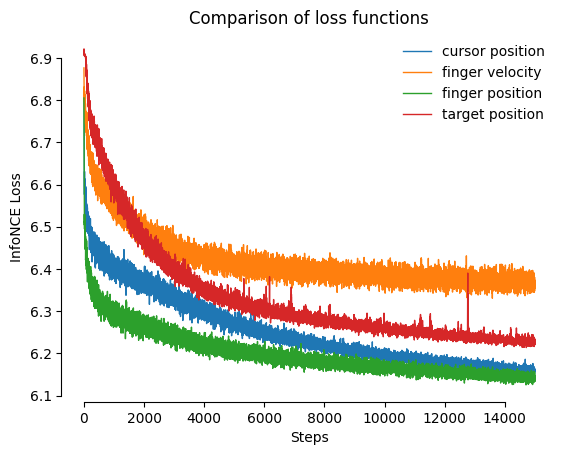

In [17]:
import matplotlib.pyplot as plt

plt.figure()

plt.title("Comparison of loss functions")

cebra.plot_loss(model_cursor_pos, ax = plt.gca(), label = "cursor position", color = "C0")
cebra.plot_loss(model_finger_vel, ax = plt.gca(), label = "finger velocity", color = "C1")
cebra.plot_loss(model_finger_pos, ax = plt.gca(), label = "finger position", color = "C2")
cebra.plot_loss(model_target_pos_index, ax = plt.gca(), label = "target position", color = "C3")
plt.legend(frameon = False)
pretty_plot()

plt.show()

## Embedding Visualization

Below we visualize the embeddings trained with the different behavioral variables outlined above.

Some helper code to sort the embedding dimensions by R², as above:

In [18]:
from sklearn.linear_model import LinearRegression

def get_best_indices_for_label(embedding, label):
    score = np.zeros(embedding.shape[1])
    for dim in range(embedding.shape[1]):
        X,y = embedding[:,dim:dim+1], dataset.cursor_pos[~is_nan]
        score[dim] = LinearRegression().fit(X, y).score(X, y)

    return np.argsort(-score)[:3]

Code for plotting all embeddings:

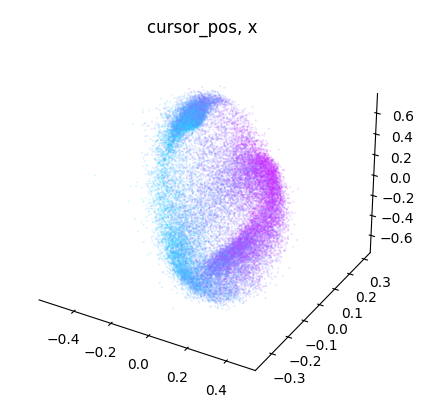

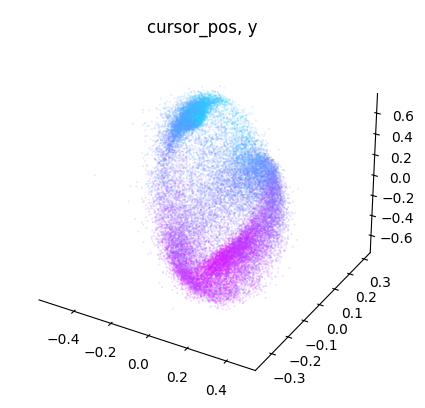

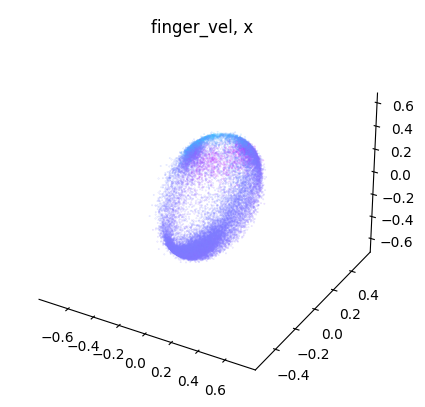

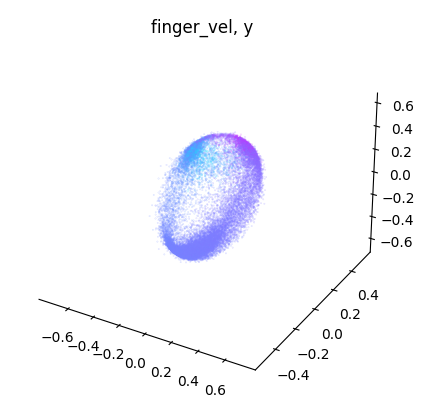

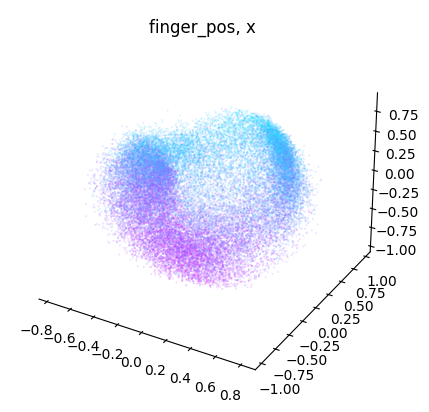

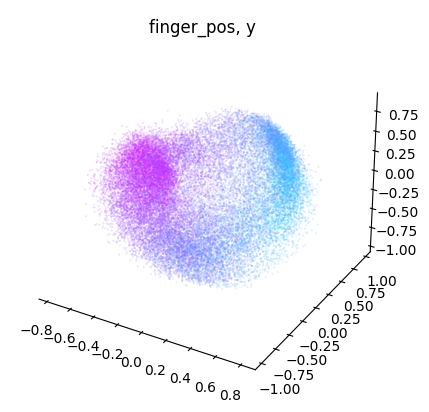

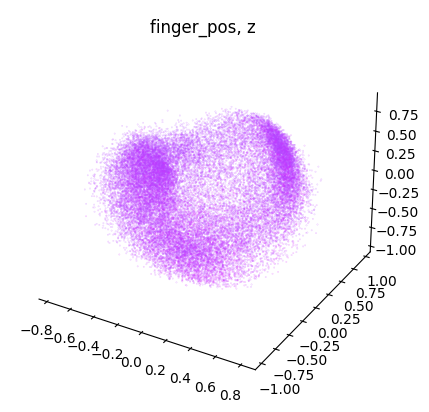

In [19]:
label_names = {
    "cursor_pos" : model_cursor_pos,
    "finger_vel" : model_finger_vel,
    "finger_pos" : model_finger_pos
}

for label_name, model in label_names.items():

    embedding = model.transform(dataset.spikes[~is_nan])
    label = getattr(dataset, label_name)[~is_nan]
    idc = get_best_indices_for_label(embedding, label)

    for dimension in range(label.shape[1]):
        dimension_label = "xyz"[dimension]
        cebra.plot_embedding(
            embedding[:, idc],
            embedding_labels = label[:, dimension],
            title = f"{label_name}, {dimension_label}"
        )